# NR Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import sys
import random as rd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as tud
# from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import CustomDataset as cd

### Loading Data

First, I'm going to try to distinguish between Carbon 130keV and Flourine 170keV.

In [2]:
C130_dat, F170_dat = np.load('data/C_130keV_10000.npy'), np.load('data/F_170keV_10000.npy')

In [3]:
data, labels = [],[]
Csum, Fsum = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append([1,0])
    Csum.append(np.sum(C130_dat[i]))

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append([0,1])
    Fsum.append(np.sum(F170_dat[i]))


Accuracy Possible with Cut of 2096 on Total Intensity: 93.67%


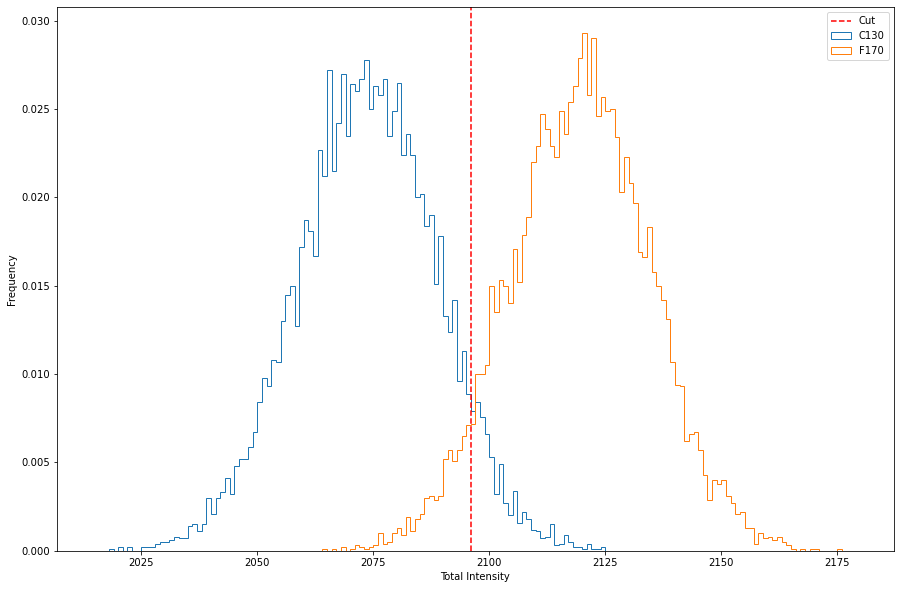

In [4]:
cut = 2096
Cless, Fgrt = [],[]
for i in range(len(Fsum)):
    if Fsum[i] > cut:
        Fgrt.append(Fsum[i])
    if Csum[i] <= cut:
        Cless.append(Csum[i])

plt.figure(figsize=(15,10))
plt.hist(Csum, density=True, histtype='step', bins=np.arange(2015,2180,1), label='C130')  # density=False would make counts
plt.hist(Fsum, density=True, histtype='step', bins=np.arange(2015,2180,1), label='F170')
plt.axvline(cut, c='r', ls='--', label='Cut')
plt.ylabel('Frequency')
plt.xlabel('Total Intensity')
plt.legend()
plt.savefig('intensity_hist.png')

Acc = (len(Fgrt)+len(Cless))/(len(Fsum)+len(Csum))*100
print('\nAccuracy Possible with Cut of {} on Total Intensity: {}%'.format(cut,Acc))

The above accuracy is a target.

In [5]:
np.max(data)

754.0

In [6]:
data_norm = data/np.max(data)

In [7]:
data_norm.shape

(20000, 97, 97)

In [8]:
dnormhist=[]
for i in range(len(data_norm)):
    dnormhist.append(np.sum(data_norm[i]))

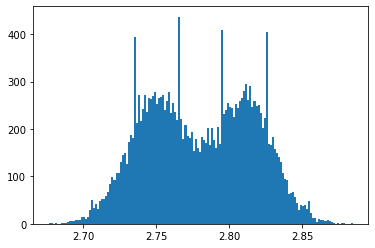

In [9]:
plt.hist(dnormhist,150);

In [10]:
np.mean(data)

0.2227727494951642

In [11]:
np.mean(data_norm)

0.00029545457492726975

For a learning algorithm, it will be necesarry to have an input (X data) containing a number of $97\times97$ matrices for each energy. The output will be a label, either Carbon or Flourine. The model will compare its output with the actual labels and adjust accordingly to minimise loss. 

In order to quantify each label, the common 'one-hot encoding' method will be used. C elements will have the label `[1, 0]` and F will be `[0, 1]`. Tuples of this form will be the ground truth labels and the model output. I will have to ensure that the model outputs an array of shape `[2]`.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_norm, labels, test_size=0.2, random_state=42)

xtrain_tensor = torch.from_numpy(np.array(X_train)) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)

ytrain_tensor = torch.from_numpy(np.array(y_train))
ytrain_sqz = ytrain_tensor.unsqueeze(1)
print(ytrain_tensor.shape)

xtest_tensor = torch.from_numpy(np.array(X_test)) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

ytest_tensor = torch.from_numpy(np.array(y_test))
ytest_sqz = ytest_tensor.unsqueeze(1)
print(ytest_tensor.shape)

train_data = cd.CustomDataset(xtrain_sqz.float(), ytrain_sqz.float())
test_data = cd.CustomDataset(xtest_sqz.float(), ytest_sqz.float())

#defining dataloader class
train_loader = tud.DataLoader(dataset=train_data, batch_size=32, shuffle=True)
train_loader_iter = iter(train_loader)

#same as above but for test data
test_loader = tud.DataLoader(dataset=test_data, batch_size=32, shuffle=True)
test_loader_iter = iter(test_loader)

torch.Size([16000, 1, 97, 97])
torch.Size([16000, 2])
torch.Size([4000, 1, 97, 97])
torch.Size([4000, 2])


torch.Size([32, 1, 97, 97])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


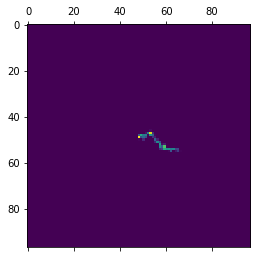

In [13]:
ttlod = []
for batch_idx, (data2,target2) in enumerate(train_loader):
    datap1=data2
    targp1=target2
print(datap1.shape)
print(datap1[0][0])
plt.matshow(datap1[0][0],fignum=1)

In [14]:
loadedhist=[]
for i in range(datap1.shape[0]):
    loadedhist.append(np.sum((datap1[i][0]).numpy()))

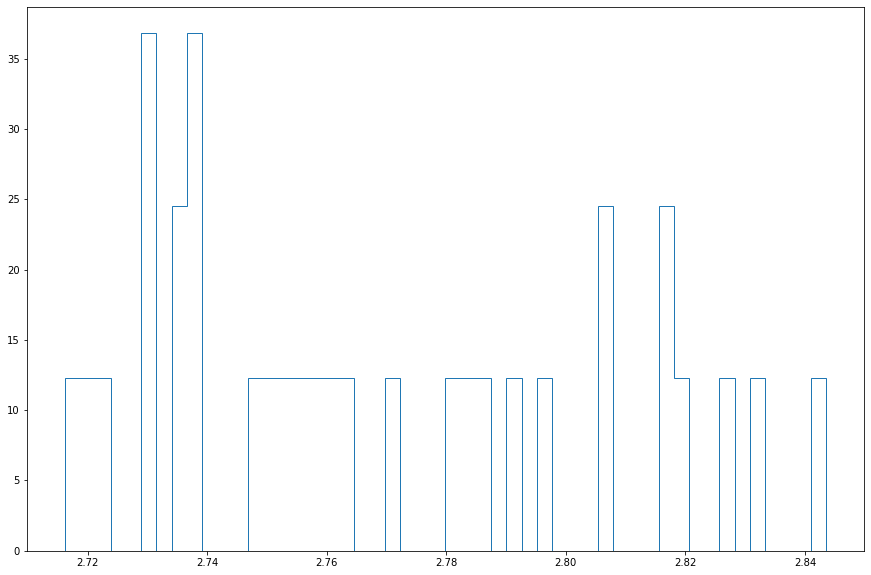

In [15]:
plt.figure(figsize=(15,10))
plt.hist(loadedhist, density=True, histtype='step', bins=50); 

In [16]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    #loop run over data output by loader to train model
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data) #applies model to data
        target = target.squeeze(1) #removes dimension from target
        loss = nn.CrossEntropyLoss()(output, target) #calculates cross entropy loss
        loss.backward()
        optimizer.step() #new step in optimisation of loss
        #printing output of each batch for loss observation while model is training
        if batch_idx % rep_step == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    #initialisting parameters and empty lists
    test_loss = 0
    correct = 0
    probs_pred = []
    labels_actual = []
    labels_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target=target.squeeze(1)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
        
            pred = output.max(1, keepdim=True)[1] #finds index of maximum in output vector as described below
            pred_onehot = F.one_hot(pred).squeeze(1) #converts into one-hot predicted label 
            pred_bool = torch.eq(pred_onehot,target) #finds values where predicted equals target
            correct += int((pred_bool.sum().item())/2) #sums number of correct values
            #adds predicted labels, targets and probabilities to lists for later use
            
            labels_actual.append(target.cpu().numpy())
            probs_pred.append(output.cpu().numpy())
            labels_pred.append(pred_onehot.cpu().numpy())
 
    #printing accuracy and loss after each epoch for analysis
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100 * correct / len(test_loader.dataset)))
    
    return(labels_actual,probs_pred,labels_pred)

torch.Size([32, 2])
tensor([1.1968e-05, 9.9999e-01], device='cuda:0')

torch.Size([32, 2])
tensor([0., 1.], device='cuda:0')

0.6635875105857849

torch.Size([32, 2])
tensor([0, 1], device='cuda:0')
tensor([True, True], device='cuda:0')
20

Test set: Average loss: 0.0053, Accuracy: 20/4000 (0%)



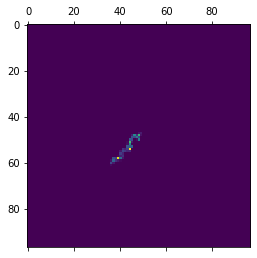

In [35]:
model.eval()
#initialisting parameters and empty lists
test_loss = 0
correct = 0
probs_pred = []
labels_actual = []
labels_pred = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        
#         print(data[0])
#         print(data.shape)
        plt.matshow(data.cpu()[0][0],fignum=1)
        
        output = model(data)
        
        print(output.shape)
        print(output[0])
        print()
        
        target=target.squeeze(1)
        print(target.shape)
        print(target[0])
        print()
        
        test_loss += nn.CrossEntropyLoss()(output, target).item()
        print(nn.CrossEntropyLoss()(output, target).item())
        print()

        pred = output.max(1, keepdim=True)[1] #finds index of maximum in output vector as described below
        
        pred_onehot = F.one_hot(pred).squeeze(1) #converts into one-hot predicted label 
        
        print(pred_onehot.shape)
        print(pred_onehot[0])
        
        pred_bool = torch.eq(pred_onehot,target) #finds values where predicted equals target
        
        print(pred_bool[0])
        
        correct += int((pred_bool.sum().item())/2) #sums number of correct values
        
        print(correct)
        
        #adds predicted labels, targets and probabilities to lists for later use

        labels_actual.append(target.cpu().numpy())
        probs_pred.append(output.cpu().numpy())
        labels_pred.append(pred_onehot.cpu().numpy())
        break

#printing accuracy and loss after each epoch for analysis
test_loss /= len(test_loader)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
100 * correct / len(test_loader.dataset)))

In [36]:
train(model, device, train_loader, optimizer, epoch)
act,pred,pred_labs = test(model, device, test_loader)

Train Epoch: 10 [0/16000 (0%)]	Loss: 0.474209
Train Epoch: 10 [1280/16000 (8%)]	Loss: 0.474849
Train Epoch: 10 [2560/16000 (16%)]	Loss: 0.402290
Train Epoch: 10 [3840/16000 (24%)]	Loss: 0.382601
Train Epoch: 10 [5120/16000 (32%)]	Loss: 0.346575
Train Epoch: 10 [6400/16000 (40%)]	Loss: 0.409666
Train Epoch: 10 [7680/16000 (48%)]	Loss: 0.429704
Train Epoch: 10 [8960/16000 (56%)]	Loss: 0.469713
Train Epoch: 10 [10240/16000 (64%)]	Loss: 0.411289
Train Epoch: 10 [11520/16000 (72%)]	Loss: 0.393980
Train Epoch: 10 [12800/16000 (80%)]	Loss: 0.358225
Train Epoch: 10 [14080/16000 (88%)]	Loss: 0.347580
Train Epoch: 10 [15360/16000 (96%)]	Loss: 0.440855

Test set: Average loss: 0.0204, Accuracy: 2568/4000 (64%)



In [37]:
np.shape(act)
np.shape(pred)
np.shape(pred_labs)

(125, 32, 2)

### Model 

In [38]:
inp = torch.randn(50, 1, 97, 97)
m = nn.Conv2d(1, 3, kernel_size=(2,2))
o = m(inp)
print(np.shape(o))
m = nn.Conv2d(3, 5, kernel_size=(2,2))
o = m(o)
print(np.shape(o))
# m = nn.Conv2d(10, 15, kernel_size=(2,2))
# o = m(o)
# print(np.shape(o))

# o = o.view(-1, 132540)
# print(np.shape(o))
# m = nn.Linear(132540,500)
# o = m(o)
# print(np.shape(o))
# m = nn.Linear(500,2)
# o = m(o)
# print(np.shape(o))

torch.Size([50, 3, 96, 96])
torch.Size([50, 5, 95, 95])


In [39]:
94*94*15

132540

In [40]:
device = torch.device('cuda')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
            
        self.fc_layers = nn.Sequential(
            nn.Linear(9409,1000),
            nn.ReLU(),
            nn.Linear(1000,100),
            nn.ReLU(),
            nn.Linear(100,2),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = x.view(-1, 9409)
        x = self.fc_layers(x)
        return x

In [41]:
# class Model2(nn.Module):
#     def __init__(self):
#         super(Model2, self).__init__()

#         self.d1 = nn.Linear(97 * 97, 1024)
#         self.d2 = nn.Linear(1024, 1024)
#         self.d3 = nn.Linear(1024, 2)

#     def forward(self, x):

#         x = x.flatten(start_dim = 1)

#         x = self.d1(x)
#         x = F.relu(x)

#         x = self.d2(x)
#         x = F.relu(x)

#         logits = self.d3(x)

#         out = F.softmax(logits, dim=1)

#         return out

In [42]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [43]:
# model = Net().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-1)

In [44]:
#outputting variables from initial model
initial_model = model
numel_list = [p.numel() for p in model.parameters()]

In [45]:
num_epochs = 10 #setting number of epochs for CNN
rep_step= 40

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

Train Epoch: 1 [0/16000 (0%)]	Loss: 0.693661
Train Epoch: 1 [1280/16000 (8%)]	Loss: 0.683684
Train Epoch: 1 [2560/16000 (16%)]	Loss: 0.684032
Train Epoch: 1 [3840/16000 (24%)]	Loss: 0.671545
Train Epoch: 1 [5120/16000 (32%)]	Loss: 0.672358
Train Epoch: 1 [6400/16000 (40%)]	Loss: 0.701236
Train Epoch: 1 [7680/16000 (48%)]	Loss: 0.651573
Train Epoch: 1 [8960/16000 (56%)]	Loss: 0.672989
Train Epoch: 1 [10240/16000 (64%)]	Loss: 0.649648
Train Epoch: 1 [11520/16000 (72%)]	Loss: 0.703232
Train Epoch: 1 [12800/16000 (80%)]	Loss: 0.713178
Train Epoch: 1 [14080/16000 (88%)]	Loss: 0.714838
Train Epoch: 1 [15360/16000 (96%)]	Loss: 0.706271

Test set: Average loss: 0.0211, Accuracy: 2296/4000 (57%)

Train Epoch: 2 [0/16000 (0%)]	Loss: 0.685594
Train Epoch: 2 [1280/16000 (8%)]	Loss: 0.619548
Train Epoch: 2 [2560/16000 (16%)]	Loss: 0.585062
Train Epoch: 2 [3840/16000 (24%)]	Loss: 0.635588
Train Epoch: 2 [5120/16000 (32%)]	Loss: 0.626518
Train Epoch: 2 [6400/16000 (40%)]	Loss: 0.663335
Train Epoch: 2

In [46]:
# model(datap1)

### All Models Tested and Observations

#### Model 1

In [47]:
inp = torch.randn(50, 1, 97, 97)
m1 = nn.Conv2d(1, 1, kernel_size=(12,12))
o1 = m1(inp)
print(np.shape(o1))
m2 = nn.MaxPool2d(kernel_size=(2,2))
o2 = m2(o1)
print(np.shape(o2))

o3 = o2.view(-1, 1849)
print(np.shape(o3))
m4 = nn.Linear(1849,500)
o4 = m4(o3)
print(np.shape(o4))
m5 = nn.Linear(500,50)
o5 = m5(o4)
print(np.shape(o5))
m6 = nn.Linear(50,2)
o6 = m6(o5)
print(np.shape(o6))

torch.Size([50, 1, 86, 86])
torch.Size([50, 1, 43, 43])
torch.Size([50, 1849])
torch.Size([50, 500])
torch.Size([50, 50])
torch.Size([50, 2])


Accuracies around 65%

Tried Sigmoid, Softmax and ReLU as final activation function. Sigmoid marginally better than Softmax. ReLU doesn't work at all.

#### Model 2

In [48]:
inp = torch.randn(50, 1, 97, 97)
m = nn.Conv2d(1, 1, kernel_size=(5,5), padding = 2)
o = m(inp)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(3,3))
o = m(o)
print(np.shape(o))
m = nn.Conv2d(1, 1, kernel_size=(5,5), padding = 2)
o = m(o)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(2,2))
o = m(o)
print(np.shape(o))
m = nn.Conv2d(1, 1, kernel_size=(3,3), padding = 1)
o = m(o)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(2,2))
o = m(o)
print(np.shape(o))


o = o.view(-1, 64)
print(np.shape(o3))
m = nn.Linear(64,20)
o = m(o)
print(np.shape(o))
m = nn.Linear(20,2)
o = m(o)
print(np.shape(o))

torch.Size([50, 1, 97, 97])
torch.Size([50, 1, 32, 32])
torch.Size([50, 1, 32, 32])
torch.Size([50, 1, 16, 16])
torch.Size([50, 1, 16, 16])
torch.Size([50, 1, 8, 8])
torch.Size([50, 1849])
torch.Size([50, 20])
torch.Size([50, 2])


Accuracies around 60%. Tried changing the learning rate but to no real effect.

Get rid of max pooling?

Small network, 2/4 channels.

Try just 1/2 linear layers. Add bias, tanh().

#### Model 3

In [49]:
inp = torch.randn(50, 1, 97, 97)
m = nn.Conv2d(1, 3, kernel_size=(5,5), padding = 2)
o = m(inp)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(3,3))
o = m(o)
print(np.shape(o))
m = nn.Conv2d(3, 3, kernel_size=(5,5), padding = 2)
o = m(o)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(2,2))
o = m(o)
print(np.shape(o))
m = nn.Conv2d(3, 5, kernel_size=(3,3), padding = 1)
o = m(o)
print(np.shape(o))
m = nn.MaxPool2d(kernel_size=(2,2))
o = m(o)
print(np.shape(o))


o = o.view(-1, 320)
print(np.shape(o3))
m = nn.Linear(320,20)
o = m(o)
print(np.shape(o))
m = nn.Linear(20,2)
o = m(o)
print(np.shape(o))

torch.Size([50, 3, 97, 97])
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 32, 32])
torch.Size([50, 3, 16, 16])
torch.Size([50, 5, 16, 16])
torch.Size([50, 5, 8, 8])
torch.Size([50, 1849])
torch.Size([50, 20])
torch.Size([50, 2])


Accuracy of 68%

#### Model 4

In [50]:
inp = torch.randn(50, 1, 97, 97)
m = nn.Conv2d(1, 3, kernel_size=(5,5), padding = 2)
o = m(inp)
print(np.shape(o))


o = o.view(-1, 28227)
m = nn.Linear(28227,20)
o = m(o)
print(np.shape(o))
m = nn.Linear(20,2)
o = m(o)
print(np.shape(o))

torch.Size([50, 3, 97, 97])
torch.Size([50, 20])
torch.Size([50, 2])


Accuracy of 60%

#### Model 5

In [51]:
inp = torch.randn(50, 1, 97, 97)

o = inp.view(-1, 9409)
m = nn.Linear(9409,2)
o = m(o)
print(np.shape(o))

torch.Size([50, 2])


Accuracy of 51%

Perhaps many channels CNN necessary.

# Trying From Scratch Again

In [52]:
C130_dat, F170_dat = np.load('data/C_130keV_10000.npy'), np.load('data/F_170keV_10000.npy')


In [53]:
data, labels = [],[]
Csum, Fsum = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append(0)
    Csum.append(np.sum(C130_dat[i]))

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append(1)
    Fsum.append(np.sum(F170_dat[i]))

In [54]:
np.random.seed(10) #fixes random seed to 10 for reproducible results
p = np.random.permutation(len(data)) #performs random permutation to get shuffled indices
data = np.array(data)[p] #applies shuffled indices to X data
labels = np.array(labels)[p] #applies shuffled indices to y data

In [55]:
data.shape

(20000, 97, 97)

In [56]:
np.mean(data)

0.2227727494951642

In [57]:
# data_norm = data/np.max(data)
data_norm = (data - np.nanmean(data,axis=0))/np.nanstd(data,axis=0)
data_norm[data_norm!=data_norm]=0

/tmp/ipykernel_27268/2423433199.py:2: RuntimeWarning: invalid value encountered in true_divide
  data_norm = (data - np.nanmean(data,axis=0))/np.nanstd(data,axis=0)


In [58]:
BATCH_SIZE=100

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data_norm, labels, test_size=0.3, random_state=42)

xtrain_tensor = torch.from_numpy(np.array(X_train)) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)

ytrain_tensor = torch.from_numpy(np.array(y_train))
print(ytrain_tensor.shape)

xtest_tensor = torch.from_numpy(np.array(X_test)) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

ytest_tensor = torch.from_numpy(np.array(y_test))
print(ytest_tensor.shape)

train_data = cd.CustomDataset(xtrain_sqz.float(), ytrain_tensor.float())
test_data = cd.CustomDataset(xtest_sqz.float(), ytest_tensor.float())

#defining dataloader class
train_loader = tud.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

#same as above but for test data
test_loader = tud.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([14000, 1, 97, 97])
torch.Size([14000])
torch.Size([6000, 1, 97, 97])
torch.Size([6000])


In [61]:
# for i, (images, labels) in enumerate(test_loader):
# #     print(images[0])
# #     plt.matshow(images[i].squeeze(0))
#     print(labels)
#     print(len(labels[labels==0]))
#     print(len(labels[labels==1]))

In [62]:
for i, (images, labels) in enumerate(test_loader):
    print(labels)
    break

tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
        1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 0., 0.])


In [63]:
# Model


# class Model1(nn.Module):
#     def __init__(self):
#         super(Model1, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
#         self.d1 = nn.Linear(95 * 95 * 32, 128)
#         self.d2 = nn.Linear(128, 2)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)

#         x = x.flatten(start_dim = 1)

#         x = self.d1(x)
#         x = F.relu(x)

#         logits = self.d2(x)
#         out = F.softmax(logits, dim=1)
#         return out


class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()

        self.d1 = nn.Linear(97 * 97, 1024)
        self.d2 = nn.Linear(1024, 1024)
        self.d3 = nn.Linear(1024, 2)

    def forward(self, x):

        x = x.flatten(start_dim = 1)

        x = self.d1(x)
        x = F.relu(x)

        x = self.d2(x)
        x = F.relu(x)

        logits = self.d3(x)

        out = F.softmax(logits, dim=1)

        return out

In [64]:
# Accuracy

def get_accuracy(logit, target, BATCH_SIZE):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/BATCH_SIZE
    return accuracy.item()

In [65]:
# Training set up

learning_rate = 0.0001
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model2() 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [66]:
# Training


for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(train_loader):

        labels=labels.type(torch.LongTensor)
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))     
    
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    print('Test Accuracy: %.2f'%( test_acc/i))

Epoch: 0 | Loss: 0.6818 | Train Accuracy: 57.77
Test Accuracy: 62.37
Epoch: 1 | Loss: 0.6450 | Train Accuracy: 63.58
Test Accuracy: 61.78
Epoch: 2 | Loss: 0.6098 | Train Accuracy: 68.62
Test Accuracy: 61.08
Epoch: 3 | Loss: 0.5678 | Train Accuracy: 74.40
Test Accuracy: 60.25
Epoch: 4 | Loss: 0.5232 | Train Accuracy: 79.72
Test Accuracy: 61.92
Epoch: 5 | Loss: 0.4824 | Train Accuracy: 84.28
Test Accuracy: 61.88
Epoch: 6 | Loss: 0.4408 | Train Accuracy: 88.75
Test Accuracy: 63.15
Epoch: 7 | Loss: 0.4120 | Train Accuracy: 91.94
Test Accuracy: 62.81
Epoch: 8 | Loss: 0.3939 | Train Accuracy: 93.62
Test Accuracy: 63.73
Epoch: 9 | Loss: 0.3832 | Train Accuracy: 94.52
Test Accuracy: 65.56


In [67]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 65.56


In [69]:
for i, (images, labels) in enumerate(test_loader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
pre_cor = (torch.max(outputs, 1)[1].view(labels.size()).data == labels.data)
corrects = (torch.max(outputs, 1)[1].view(labels.size()).data == labels.data).sum()
accuracy = 100.0 * corrects/BATCH_SIZE

In [70]:
pre_cor

tensor([False,  True, False, False, False, False, False,  True,  True,  True,
         True, False,  True, False,  True,  True,  True,  True, False,  True,
         True,  True, False, False,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False, False, False,  True,
        False,  True,  True,  True,  True,  True, False,  True, False, False,
         True,  True, False,  True,  True,  True, False, False,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True, False, False,
        False,  True,  True,  True, False,  True,  True, False,  True,  True,
        False, False, False,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')

In [71]:
corrects

tensor(66, device='cuda:0')

In [72]:
labels

tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
        0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        1., 0., 1., 1., 0., 1., 1., 1., 0., 1.], device='cuda:0')

In [73]:
outputs

tensor([[7.9628e-02, 9.2037e-01],
        [2.5742e-02, 9.7426e-01],
        [9.6558e-01, 3.4415e-02],
        [1.9591e-01, 8.0409e-01],
        [9.9821e-01, 1.7863e-03],
        [4.9827e-01, 5.0173e-01],
        [4.3527e-01, 5.6473e-01],
        [9.2946e-03, 9.9071e-01],
        [1.8305e-03, 9.9817e-01],
        [1.0000e+00, 0.0000e+00],
        [9.5563e-01, 4.4370e-02],
        [8.7076e-04, 9.9913e-01],
        [9.8961e-01, 1.0392e-02],
        [1.6473e-01, 8.3527e-01],
        [9.6140e-01, 3.8598e-02],
        [1.0000e+00, 2.4965e-35],
        [1.0000e+00, 7.6161e-13],
        [8.4596e-01, 1.5404e-01],
        [9.9135e-01, 8.6518e-03],
        [8.6069e-01, 1.3931e-01],
        [1.1850e-02, 9.8815e-01],
        [4.0610e-04, 9.9959e-01],
        [9.7864e-01, 2.1357e-02],
        [1.0000e+00, 9.3502e-07],
        [1.0000e+00, 5.4110e-24],
        [4.8130e-04, 9.9952e-01],
        [1.0000e+00, 2.8142e-09],
        [1.5726e-04, 9.9984e-01],
        [3.5309e-02, 9.6469e-01],
        [3.533